In [9]:

import mne


import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
import eelbrain as eel

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert

from collections import Counter

import sys
sys.path.append('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *

import pickle
import os

In [10]:
eeg_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_15Hz'
mTRF_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/trained_models'
sv_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv'


## Subjects and parameters

In [30]:

#good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects
#subjects_to_process = ['06']
#subjects_to_process =['01', '04', '05', '06', '07', '08', '09', '10', '11', '12']

n_subs = len(subjects_to_process)
print('processing subjects:', subjects_to_process)

periods = ['pre']
#features = 'AM' #AM or onsets

overwrite = False
n_segments = 10
fs = 128
tmin, tmax =-0.5, 0.5  # range of time lag
regularization = 1



processing subjects: ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


## Train reverse TRF model

In [31]:
train = 'listen' #listen or error
save = True

for subject in subjects_to_process:
    print(f'processing subject {subject}')
    for period in periods:

        if train == 'error':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat')
            
            data = loadmat(eeg_path)
            eeg = data['trial_data']

            #error events are already pre-extracted and sorted by first or others so sv can be customized to reflect surprisal
            sv_data = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))
            onsets_sv = sv_data['onsets'][0] #take 0 index because it's shaped (1, n_timepoints)

        elif train == 'listen':
            eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_listen_{period}_{subject}.mat')
            data = loadmat(eeg_path)
            eeg = data['trial_data']

            
            #get listening events and make support vector
            events_sv = data['events']
            events_arr = make_raw_events(events_sv)
            events_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
            onset_indices = events_keystrokes[:,0]
            onsets_sv = np.zeros_like(events_sv[0])
            onsets_sv[onset_indices] = 1
        
        

        eeg_segments = segment(eeg.T, n_segments)
        eeg_segments_norm = normalize_responses(eeg_segments)

        onset_segments = segment(onsets_sv, n_segments) 


        #train model
        bwd_trf = TRF(direction = -1)
        bwd_trf.train(onset_segments, eeg_segments_norm, fs, tmin, tmax, regularization = regularization)

        #save model
        if save: 
         if not os.path.exists(mTRF_path):
            os.mkdir(mTRF_path)
         bwd_trf.save(os.path.join(mTRF_path, f'rTRF_{train}_{subject}_{period}.pkl'))

        

processing subject 01
processing subject 04
processing subject 05
processing subject 06
processing subject 07
processing subject 08
processing subject 09
processing subject 10
processing subject 11
processing subject 12
processing subject 13
processing subject 14
processing subject 15
processing subject 16
processing subject 17
processing subject 18
processing subject 19
processing subject 20


## Using reverse TRF to predict stimulus

In [27]:
def load_stim_resp(subject, period, n_segments, eeg_dir, stim_dir, normalize = True, stim_sv = 'firsts'):
    """ 
    Loads the error eeg and onsets information
    stim_sv: either 'onsets' (loads sv where all onsets are 1) or 'firsts' (where all firsts are 1 and others are slightly smaller)
     ---
    returns:
    sv_segments: stimulus, segmented into n_segments
    eeg_segments: eeg response, segmented into n_segments
    """

    data_err = loadmat(os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat'))
    eeg_err = data_err['trial_data'].T

    
    sv_data_err = loadmat(os.path.join(stim_dir, f'sv_data_{period}_{subject}.mat'))

    if stim_sv == 'onsets':
        sv = sv_data_err['onsets'][0]
    elif stim_sv == 'firsts':
        sv = sv_data_err['firsts'][0]
    
    #crop EEG if it's longer than support vector (sv is always 10 mins long but subs 01 and 04 have shorter recordings)
    if sv.shape[0] > eeg_err.shape[0]:
        sv = sv[:eeg_err.shape[0]]

    
   
    eeg_segments = segment(eeg_err, n_segments)
    sv_segments = segment(sv,n_segments)

    #normalize EEG segmenets
    if normalize:
        eeg_segments = normalize_responses(eeg_segments)

    return sv_segments, eeg_segments


def concat_segments(segments):
    """
    reconcatenate segmented data
    """
    concat = np.stack(segments).squeeze()
    concat = concat.reshape(-1)
    return concat

def find_trf_preds(model, stimulus, response):
    """ 
    Predicts stimulus and concatenates the results so it can be easily plotted against ground truth

    ---
    Returns: 
    prediction (concatenated to be same shape as unsegmented stimulus)


    """
    #prediction using trf model
    res = model.predict(stimulus, response) 
        #res[0] is the prediction of the stimulus. List of len n_segments, where each element is the size of one stimlus segment
        #res[1] is a metric to measure how good the prediction is. By default it is pearson r

    #get reconstructed stimulus
    prediction = res[0]
    prediction = np.stack(prediction).squeeze()
    #concatenate prediction segments so they can be plotted against ground truth
    pred_concat = prediction.reshape(-1)

    #get prediction metric
    pred_metric = res[1]

    return pred_concat, pred_metric


def load_trf_model(subject, period, mTRF_path):
    with open(os.path.join(mTRF_path, f'rTRF_listen_{subject}_{period}.pkl'), 'rb') as file:
        bwd_trf = pickle.load(file)
    return bwd_trf

In [29]:
for subject in subjects_to_process:
    print(f'processing {subject}')

    sv, eeg = load_stim_resp(subject, period, n_segments, eeg_dir, sv_dir, stim_sv='onsets') #load stim
    print(len(sv))
    
    #load model and predict
    bwd_trf = load_trf_model(subject, period, mTRF_path)
    pred_concat, pred_metric = find_trf_preds(bwd_trf, sv, eeg)

    #save predictions
    preds = {
        'predicted_stim': pred_concat,
        'pearsonr': pred_metric
    }


    preds_path = './rTRF_predictions/'
    if not os.path.exists(preds_path):
        os.mkdir(preds_path)

    savemat(os.path.join(preds_path, f'pred_err_{subject}_{period}.mat'), preds)

processing 01
(76800,) (76800, 64)
10
processing 04
(76800,) (46068, 64)
10
processing 05
(76800,) (76800, 64)
10
processing 06
(76800,) (76800, 64)
10
processing 07
(76800,) (76800, 64)
10
processing 08
(76800,) (76800, 64)
10
processing 09
(76800,) (76800, 64)
10
processing 10
(76800,) (76800, 64)
10
processing 11
(76800,) (76800, 64)
10
processing 12
(76800,) (76800, 64)
10
processing 13
(76800,) (76343, 64)
10
processing 14
(76800,) (76800, 64)
10
processing 15
(76800,) (76800, 64)
10
processing 16
(76800,) (76800, 64)
10
processing 17
(76800,) (74462, 64)
10
processing 18
(76800,) (76800, 64)
10
processing 19
(76800,) (76800, 64)
10
processing 20
(76800,) (76800, 64)
10


Text(0, 0.5, 'amplitude')

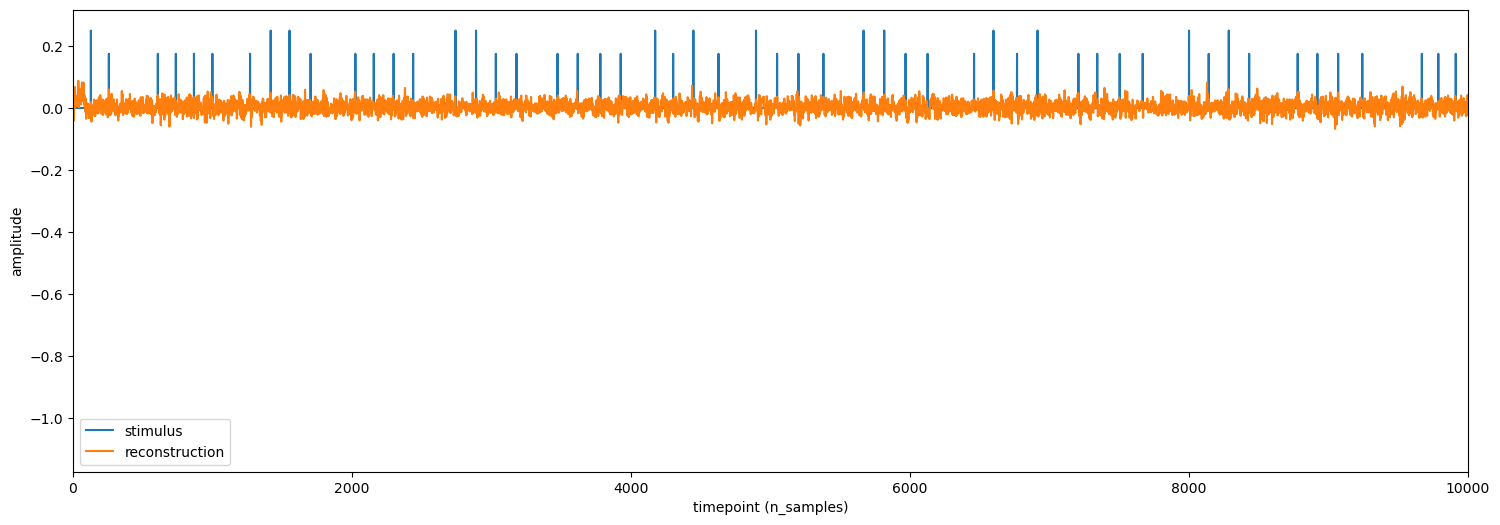

In [ ]:
#sanity check

# plt.figure(figsize = (18,6))
# plt.plot(firsts_sv_err/4, label = 'stimulus')
# plt.plot(pred_concat, label = 'reconstruction')
# plt.xlim(0,10000)

# plt.legend(loc = 'lower left')
# plt.xlabel('timepoint (n_samples)')
# plt.ylabel('amplitude')